# **Deep Learning Project**

## Rare Species Classification
### Model: Transfer Learning (EfficientNetV2B0)

### Imports and Configuration

Here we import the necessary libraries 

In [39]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

### Data Organization

We define the file paths and organize the raw images into training, validation, and test directories. We use stratified sampling to ensure that every rare species is equally represented across all three sets. The code checks if the data is already organized and skips this step if it finds the existing folders.

In [ ]:
METADATA_PATH = "metadata.csv" 
IMAGE_ROOT_DIR = "rare_species" 
DATA_DIR = "data" 
MODELS_DIR = "models" 

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs("results", exist_ok=True)

# Function to split and organize the dataset
def perform_stratified_split(metadata_df, image_root, data_target_dir='data'):
    print("Organizing data. This might take a moment.")
    X = metadata_df['file_path']
    y = metadata_df['family']

    # Split out 10% for testing
    split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
    for temp_idx, test_idx in split_1.split(X, y):
        test_set = metadata_df.iloc[test_idx]
        temp_set = metadata_df.iloc[temp_idx]

    # Split the remaining 90% into 80% Train and 10% Validation
    split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=42) 
    for train_idx, val_idx in split_2.split(temp_set, temp_set['family']):
        train_set = temp_set.iloc[train_idx]
        val_set = temp_set.iloc[val_idx]

    # Copy files to the target directories
    def copy_files(df, split_name):
        target_split_dir = os.path.join(data_target_dir, split_name)
        os.makedirs(target_split_dir, exist_ok=True)
        for _, row in df.iterrows():
            family = str(row['family'])
            src = os.path.join(image_root, row['file_path'])
            dst_dir = os.path.join(target_split_dir, family)
            os.makedirs(dst_dir, exist_ok=True)
            if os.path.exists(src):
                shutil.copy(src, os.path.join(dst_dir, os.path.basename(src)))
    
    copy_files(train_set, 'train')
    copy_files(val_set, 'validation')
    copy_files(test_set, 'test')
    print("Data split and organization complete.")

# Check if data exists and run the split if needed
if not os.path.exists(os.path.join(DATA_DIR, 'train')):
    if os.path.exists(METADATA_PATH):
        df = pd.read_csv(METADATA_PATH)
        perform_stratified_split(df, IMAGE_ROOT_DIR, DATA_DIR)
    else:
        print("Error: metadata.csv not found.")
else:
    print("Organized data found. Skipping split.")

Organized data found. Skipping split.


### Load Pre-trained Model

We load the EfficientNetV2B0 model with weights pre-trained on the ImageNet dataset. We exclude the top classification layer and freeze the base layers. This ensures we preserve the learned features and do not update them during the initial training phase.

In [41]:
base_model = EfficientNetV2B0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

### Build Model Architecture

We construct the final model by adding a custom classification head to the EfficientNet base. We use global average pooling to reduce dimensions, followed by batch normalization and dropout to stabilize training. The final dense layer uses a softmax activation function to classify the images into our specific categories.

In [ ]:
# Get number of classes from the data directory
num_classes = len(os.listdir(os.path.join(DATA_DIR, 'train')))

# We define the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,685,978 (25.50 MB)

 Trainable params: 763,082 (2.91 MB)

 Non-trainable params: 5,922,896 (22.59 MB)

### Data Generators

We initialize data generators to feed images into the model. We include a custom preprocessing function to handle grayscale images by converting them to RGB. For the training set, we apply real-time data augmentation, including rotation, shifting, and zooming, to help the model generalize better.

In [ ]:
def custom_preprocess(image):
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image

# Define augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation or test
val_test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
)

# Create the generators
print("Loading data from directories...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Calculate class weights to handle imbalance
y_train = train_generator.classes
class_weights_arr = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_arr))

Loading data from directories...


Found 9585 images belonging to 202 classes.
Found 1199 images belonging to 202 classes.
Found 1199 images belonging to 202 classes.


### Phase 1: Train Head

We compile the model using the Adam optimizer and categorical crossentropy loss. We then train only the custom head layers for 12 epochs while the base model remains frozen. This allows the new layers to learn useful patterns before we fine-tune the entire network.

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase1 = [
    ModelCheckpoint('models/best_phase1.weights.h5', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

In [46]:
# Phase 1 training
history_p1 = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    class_weight=class_weights
)

model.save('models/efficientnet_phase1_full.keras')

Epoch 1/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.2649 - loss: 3.9119

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from None to 2.45627, saving model to models/best_phase1.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 232s 775ms/step - accuracy: 0.3246 - loss: 3.5116 - val_accuracy: 0.5263 - val_loss: 2.4563 - learning_rate: 0.0010
Epoch 2/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.4706 - loss: 2.6606
Epoch 2: val_loss improved from 2.45627 to 2.28238, saving model to models/best_phase1.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 213s 711ms/step - accuracy: 0.4700 - loss: 2.6417 - val_accuracy: 0.5847 - val_loss: 2.2824 - learning_rate: 0.0010
Epoch 3/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5352 - loss: 2.3709
Epoch 3: val_loss improved from 2.28238 to 2.20495, saving model to models/best_phase1.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 209s 695ms/step - accuracy: 0.5321 - loss: 2.3885 - val_accuracy: 0.6105 - val_loss: 2.2050 - learning_rate: 0.0010
Epoch 4/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5774 - loss: 2.2214
Epoch 4: 

### Phase 2 Setup: Fine-Tuning

We unfreeze the base model to allow fine-tuning of its weights. To preserve the general features learned from ImageNet, we keep the bottom 200 layers frozen and only train the top layers. We also lower the learning rate significantly to ensure stable training.

In [26]:
# Setting up Phase 2 fine-tuning

# Access the base model which is the first layer
base_model_layer = model.layers[0]
base_model_layer.trainable = True

# Freeze the bottom 200 layers
for layer in base_model_layer.layers[:200]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,685,978 (25.50 MB)

 Trainable params: 763,082 (2.91 MB)

 Non-trainable params: 5,922,896 (22.59 MB)

### Phase 2: Train Full Model

We continue training the model with the unfrozen layers for 20 more epochs. This step allows the model to adapt the pre-trained features specifically to our rare species dataset, improving final accuracy.

In [27]:
callbacks_phase2 = [
    ModelCheckpoint('models/best_phase2.weights.h5', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Phase 2 training

history_p2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights
)

model.save('models/efficientnet_final.keras')

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7208 - loss: 1.7261
Epoch 1: val_loss improved from None to 2.02147, saving model to models/best_phase2.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 244s 755ms/step - accuracy: 0.7177 - loss: 1.7304 - val_accuracy: 0.6747 - val_loss: 2.0215 - learning_rate: 1.0000e-05
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7277 - loss: 1.6952
Epoch 2: val_loss improved from 2.02147 to 2.01523, saving model to models/best_phase2.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 213s 710ms/step - accuracy: 0.7237 - loss: 1.6983 - val_accuracy: 0.6747 - val_loss: 2.0152 - learning_rate: 1.0000e-05
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7162 - loss: 1.7206
Epoch 3: val_loss improved from 2.01523 to 2.00973, saving model to models/best_phase2.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 209s 698ms/step - accuracy: 0.7240 - loss: 1.6972 - val_accuracy: 0.6789 - val_loss: 2.0097 - learning_rate: 1.0000e-0

### Learning Curves

We visualize the training process by plotting the accuracy and loss for both training phases combined. This helps us assess if the model converged well and check for any signs of overfitting or underfitting. We also display all the metrics like accuracy, precision F1 score and recall

We generate a confusion matrix to visualize the model's predictions versus the true labels and report how are the classes predicted exactly

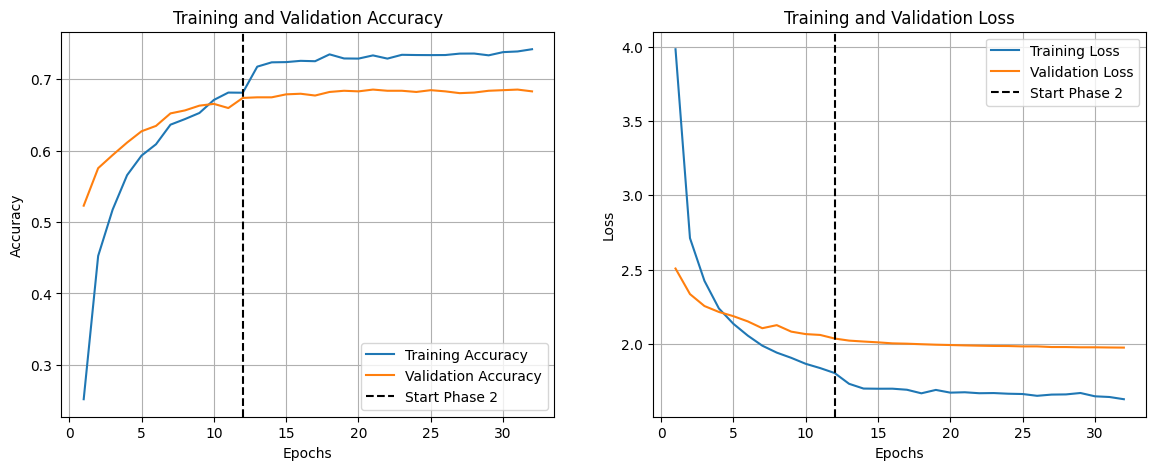

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step
Final test metrics
Accuracy:          71.89%
Macro F1-Score:    69.81%
Macro Precision:   72.01%
Macro Recall:      72.39%
Report saved: results/classification_report.csv

Generating Confusion Matrix...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

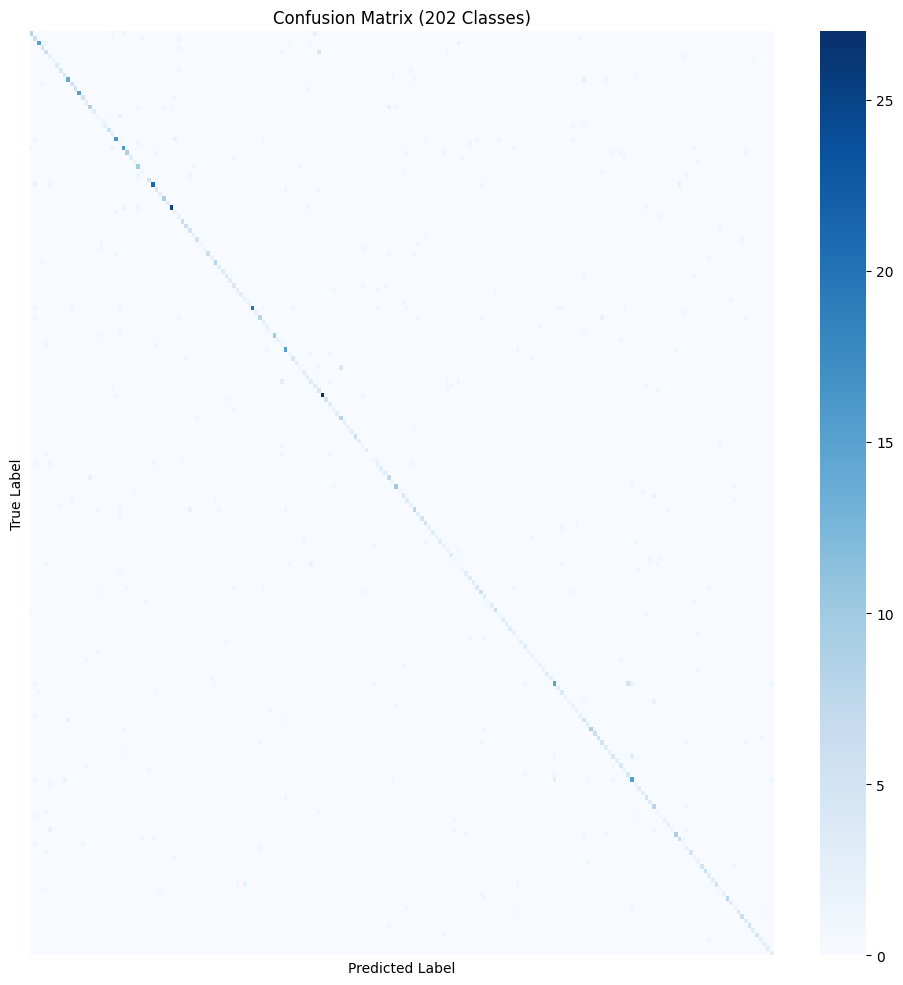

In [ ]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    classification_report, 
    confusion_matrix
)

# Combine history from Phase 1 and Phase 2
acc = history_p1.history['accuracy'] + history_p2.history['accuracy']
val_acc = history_p1.history['val_accuracy'] + history_p2.history['val_accuracy']
loss = history_p1.history['loss'] + history_p2.history['loss']
val_loss = history_p1.history['val_loss'] + history_p2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
# Add a vertical line to show where Phase 2 (Fine-Tuning) started
plt.axvline(x=len(history_p1.history['accuracy']), color='black', linestyle='--', label='Start Phase 2')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history_p1.history['loss']), color='black', linestyle='--', label='Start Phase 2')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
prec_macro = precision_score(y_true, y_pred, average='macro')
rec_macro = recall_score(y_true, y_pred, average='macro')

print("Final test metrics")
print(f"Accuracy:          {acc:.2%}")
print(f"Macro F1-Score:    {f1_macro:.2%}")
print(f"Macro Precision:   {prec_macro:.2%}")
print(f"Macro Recall:      {rec_macro:.2%}")

# Report to see which classes were not predicted
report_dict = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv('results/classification_report.csv')
print("Report saved: results/classification_report.csv")

# Confusion Matrix
print("\nGenerating Confusion Matrix...")
plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.title(f'Confusion Matrix ({len(test_generator.class_indices)} Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('results/confusion_matrix.png')
plt.show()